In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat

# Step 1: Define path to folder containing the JSON files
json_folder_path = r'D:\04_22_2025\data\bang_bang\control_actions'

# Step 2: Read all JSON files and normalize into a single DataFrame
all_energy_data = []

for json_file in os.listdir(json_folder_path):
    if json_file.endswith('.json'):
        full_path = os.path.join(json_folder_path, json_file)
        with open(full_path, 'r') as file:
            try:
                json_data = json.load(file)
                json_data['source_file'] = json_file  # Track file origin
                df = pd.json_normalize(json_data)
                all_energy_data.append(df)
            except json.JSONDecodeError:
                print(f"Error decoding {json_file}")

# Combine all data
energy_df = pd.concat(all_energy_data, ignore_index=True)

# Step 3: Parse timestamps and clean
energy_df = energy_df.dropna(subset=['energy_data.timestamp'])
energy_df['timestamp'] = pd.to_datetime(energy_df['energy_data.timestamp'])
energy_df.set_index('timestamp', inplace=True)
energy_df.sort_index(inplace=True)

# Step 4: Define experiment start and end manually (adjust if needed)
experiment_start = pd.to_datetime("2025-04-22 15:03:54")  # <- actual start time
experiment_end = pd.to_datetime("2025-04-22 21:01:40")    # <- 6 hours later

# Filter to 6-hour experiment duration
experiment_df = energy_df.loc[experiment_start:experiment_end]

# Step 5: Convert time to minutes since experiment start
minutes_from_start = (experiment_df.index - experiment_start).total_seconds() / 60

# Step 6: Plot with high resolution
plt.figure(figsize=(12, 6), dpi=1000)
plt.plot(minutes_from_start, experiment_df['energy_data.total_energy'], linewidth=2)
plt.title('Bang-Bang Control: Time vs Energy')
plt.xlabel('Time (minutes)')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Folder path for temperature logs
temp_folder = r"D:\04_22_2025\data\bang_bang\temperatures"
experiment_start = pd.to_datetime("2025-04-22 15:03:38")
experiment_end = pd.to_datetime("2025-04-22 21:01:39")

# Collect temperature records
temp_records = []

for filename in os.listdir(temp_folder):
    if filename.startswith('temps_2025-04-22') and filename.endswith('.json'):
        file_path = os.path.join(temp_folder, filename)
        with open(file_path, 'r') as file:
            try:
                data = json.load(file)
                if 'temperatures' in data and 'timestamp' in data:
                    flat_record = data['temperatures'].copy()
                    flat_record['timestamp'] = data['timestamp']
                    temp_records.append(flat_record)
            except json.JSONDecodeError:
                print(f"Could not decode {filename}")

# Convert to DataFrame
if not temp_records:
    raise ValueError("No temperature records found. Check file names and structure.")

temp_df = pd.DataFrame(temp_records)

# ✅ Convert 'timestamp' to datetime
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
temp_df.set_index('timestamp', inplace=True)
temp_df.sort_index(inplace=True)

# ✅ Filter only the 6-hour experiment window
temp_df = temp_df.loc[experiment_start:experiment_end]

# ✅ Add minutes since experiment start
temp_df['minutes_since_start'] = (temp_df.index - experiment_start).total_seconds() / 60

# ✅ Plot
plt.figure(figsize=(14, 6), dpi=1000)
for col in [c for c in temp_df.columns if c not in ['Ambient', 'minutes_since_start']]:
    plt.plot(temp_df['minutes_since_start'], temp_df[col], label=col)

# Add comfort zone
plt.axhspan(70, 80, color='green', alpha=0.1, label='Comfort Range (70–80°F)')

# Labeling
plt.title("Bang-Bang Control: Room Temperatures (04/15/2025)")
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


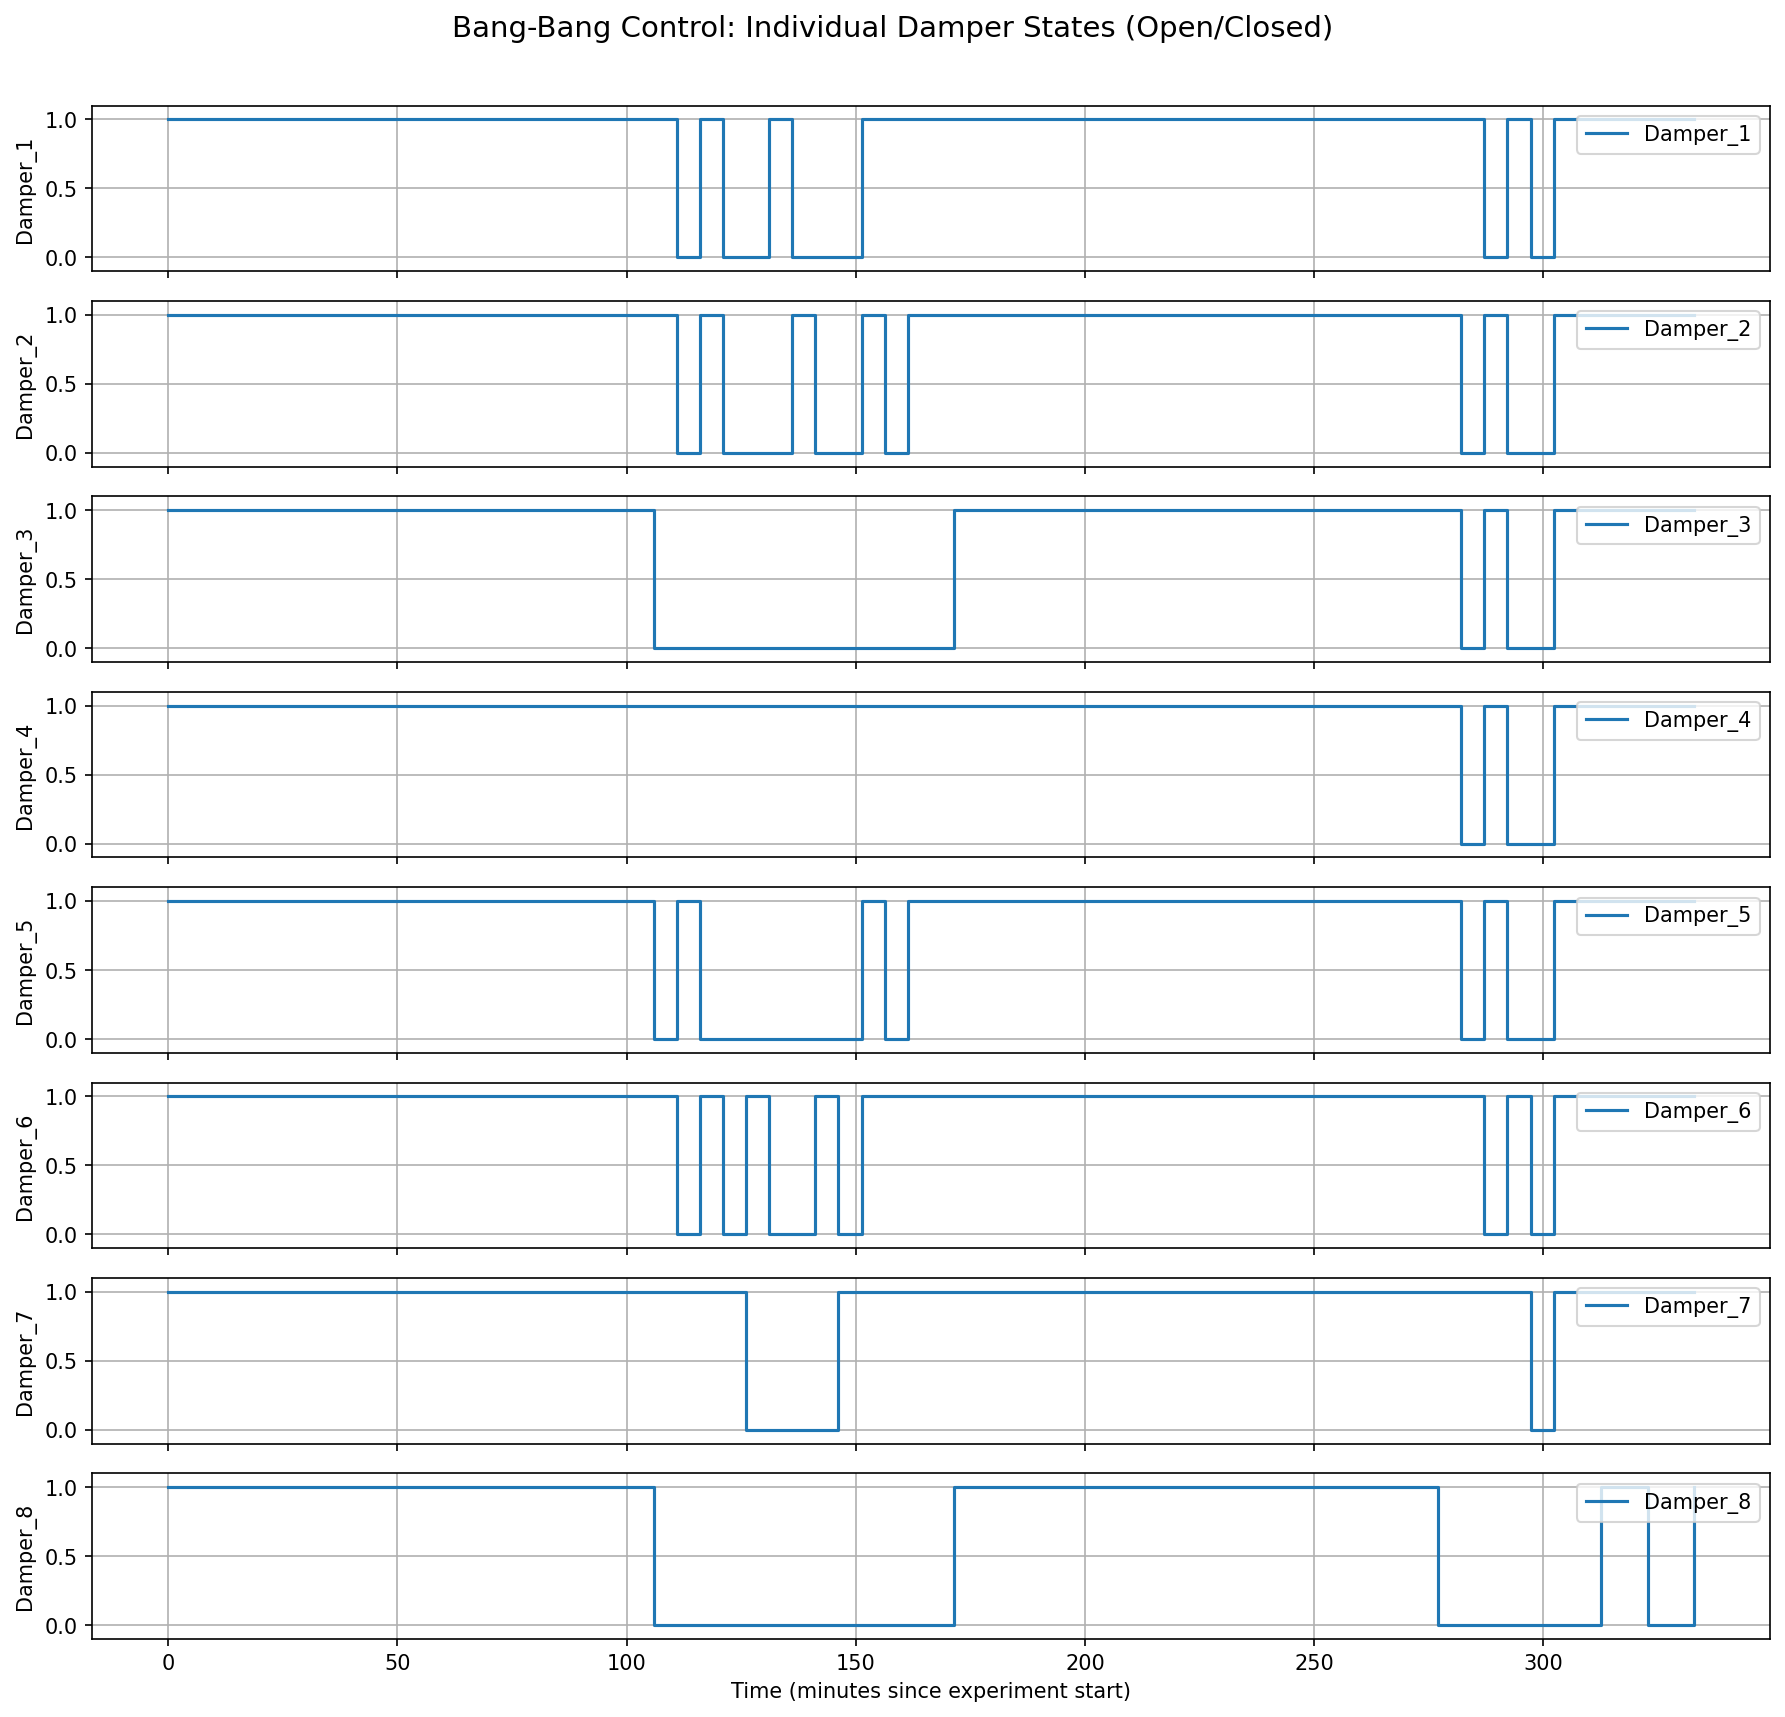

In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
base_folder = r"D:\04_22_2025\data\bang_bang\control_actions"
experiment_start = pd.to_datetime("2025-04-22 15:03:38")
# ----------------------------------------

# -------- Load Damper Data --------------
damper_records = []

for file in os.listdir(base_folder):
    if file.startswith('dampers_2025-04-22') and file.endswith('.json'):
        path = os.path.join(base_folder, file)
        with open(path, 'r') as f:
            try:
                data = json.load(f)
                if 'timestamp' in data and 'damper_positions' in data:
                    # Convert damper positions to binary (1 = open, 0 = closed)
                    damper_entry = {
                        f'Damper_{i+1}': 1 if pos != 0 else 0
                        for i, pos in enumerate(data['damper_positions'])
                    }
                    damper_entry['timestamp'] = data['timestamp']
                    damper_records.append(damper_entry)
            except json.JSONDecodeError:
                print(f"Failed to decode {file}")

damper_df = pd.DataFrame(damper_records)
damper_df['timestamp'] = pd.to_datetime(damper_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
damper_df.set_index('timestamp', inplace=True)
damper_df.sort_index(inplace=True)
damper_df['minutes_since_start'] = (damper_df.index - experiment_start).total_seconds() / 60

# -------- Plot Each Damper in a Separate Subplot --------
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 12), dpi=150, sharex=True)

for i in range(8):
    damper_name = f'Damper_{i+1}'
    axes[i].step(damper_df['minutes_since_start'], damper_df[damper_name], where='post', label=damper_name)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_ylabel(f'{damper_name}')
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (minutes since experiment start)")
fig.suptitle("Bang-Bang Control: Individual Damper States (Open/Closed)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


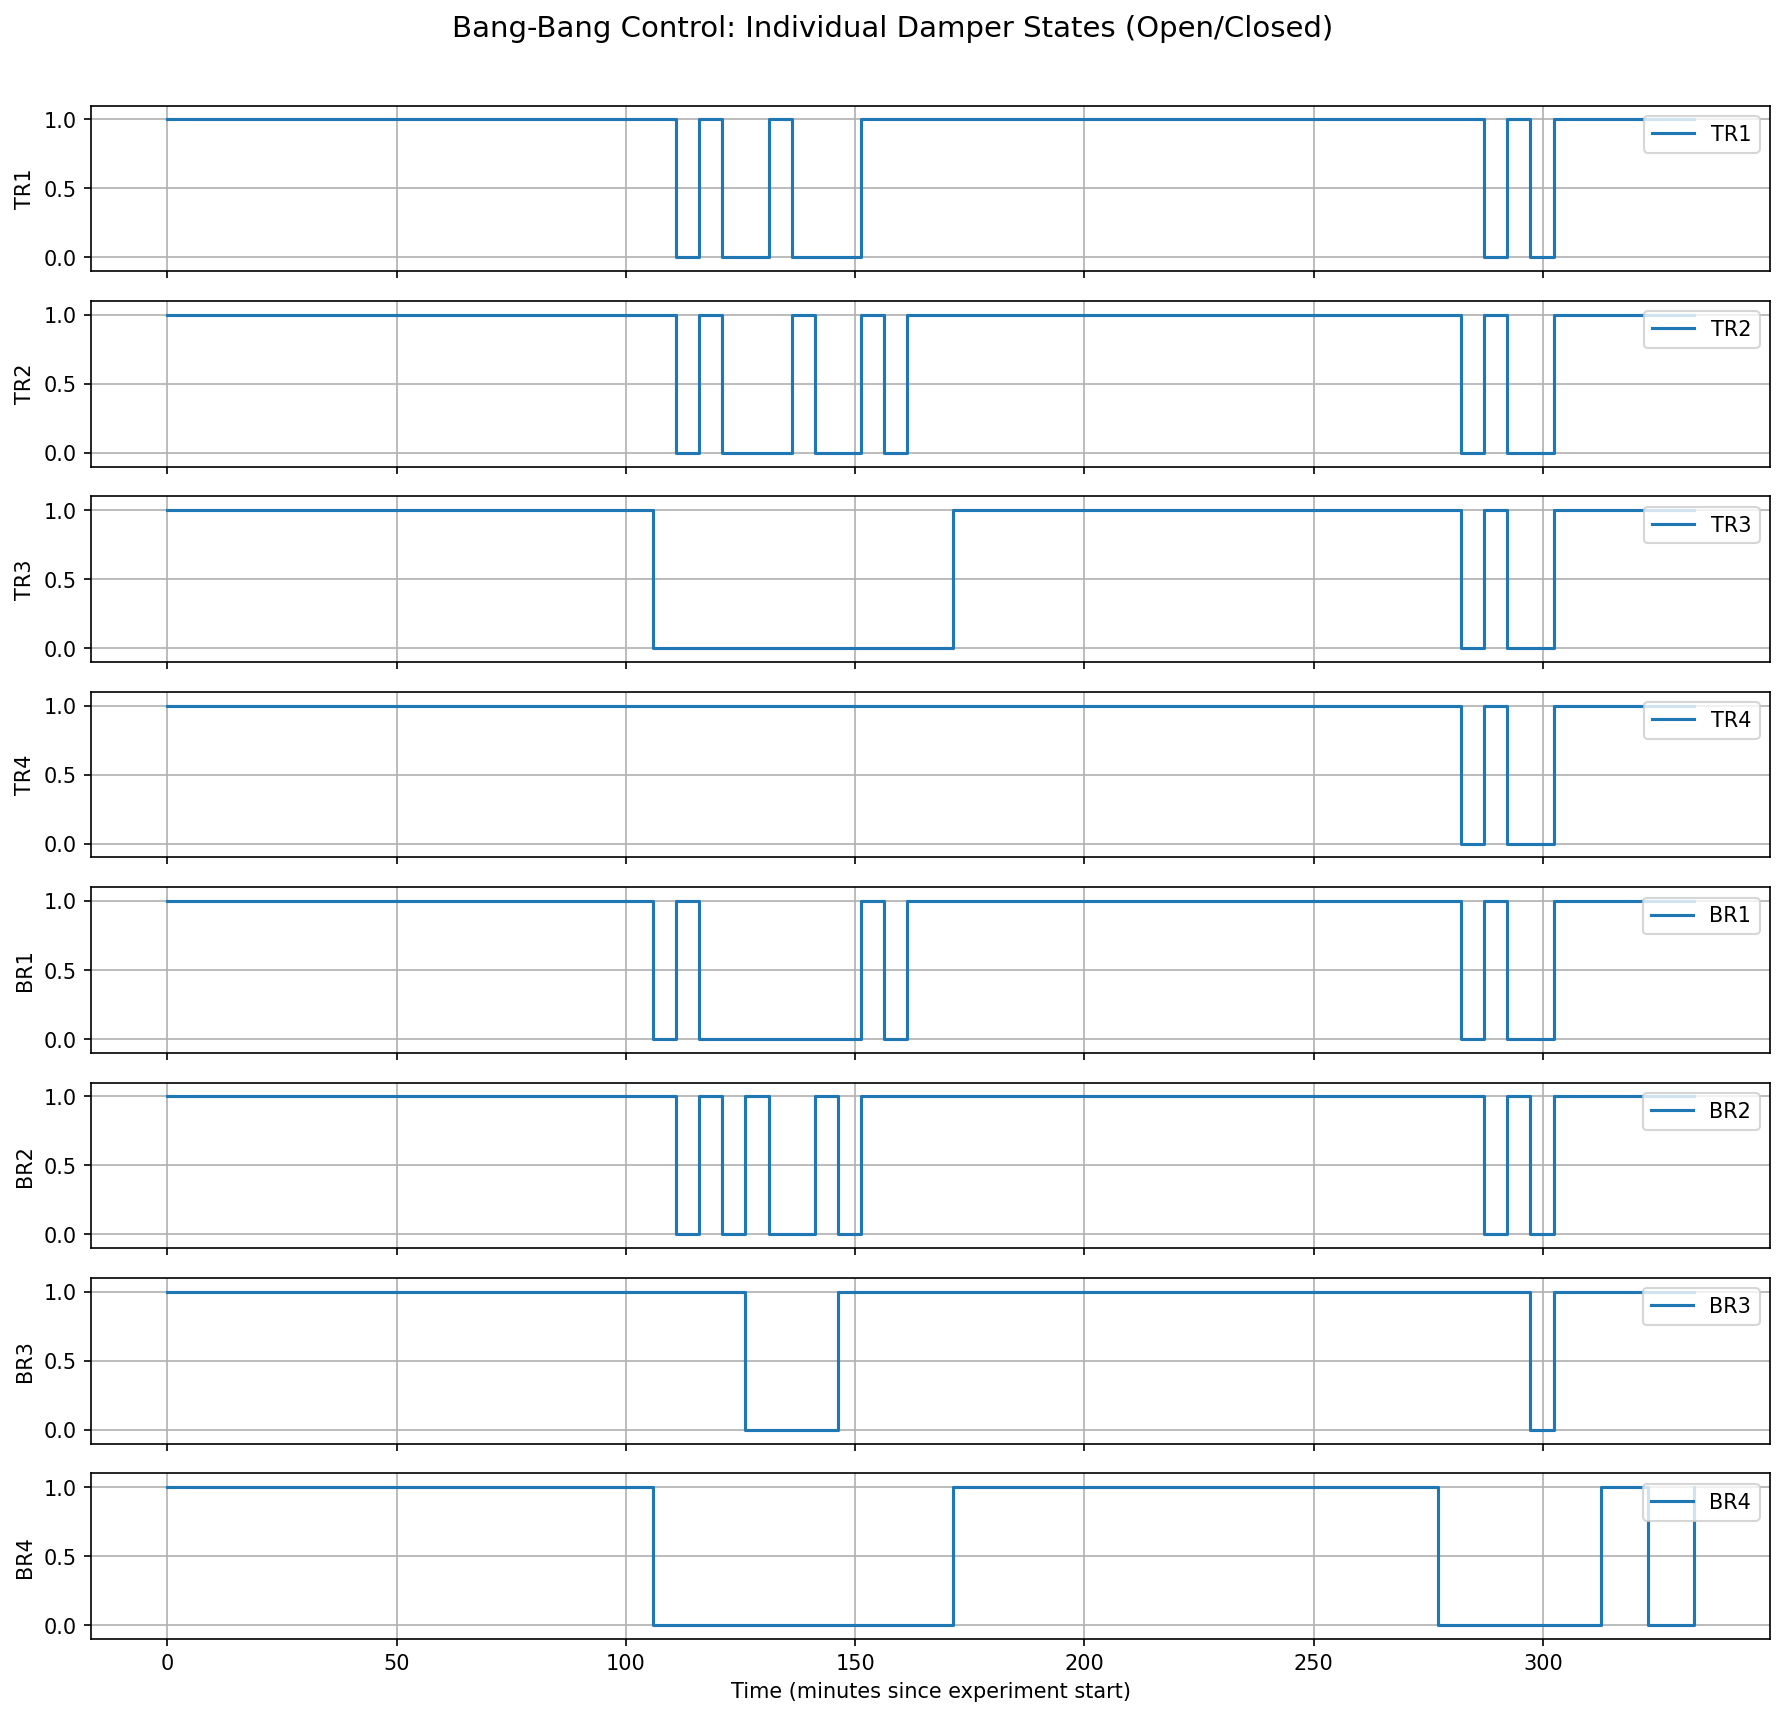

In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
base_folder = r"D:\04_22_2025\data\bang_bang\control_actions"
experiment_start = pd.to_datetime("2025-04-22 15:03:38")
# ----------------------------

# Room mapping based on damper index
room_map = {
    1: "TR1", 2: "TR2", 3: "TR3", 4: "TR4",
    5: "BR1", 6: "BR2", 7: "BR3", 8: "BR4"
}

# -------- Load Damper Data ----------
damper_records = []

for file in os.listdir(base_folder):
    if file.startswith('dampers_2025-04-22') and file.endswith('.json'):
        file_path = os.path.join(base_folder, file)
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
                if 'timestamp' in data and 'damper_positions' in data:
                    binary_dampers = {
                        f'Damper_{i+1}': 1 if pos != 0 else 0
                        for i, pos in enumerate(data['damper_positions'])
                    }
                    binary_dampers['timestamp'] = data['timestamp']
                    damper_records.append(binary_dampers)
            except json.JSONDecodeError:
                print(f"Error decoding {file}")

# -------- Convert to DataFrame ----------
damper_df = pd.DataFrame(damper_records)
damper_df['timestamp'] = pd.to_datetime(damper_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
damper_df.set_index('timestamp', inplace=True)
damper_df.sort_index(inplace=True)

# Calculate time in minutes since experiment start
damper_df['minutes_since_start'] = (damper_df.index - experiment_start).total_seconds() / 60

# -------- Plot Each Damper in a Subplot ----------
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 12), dpi=150, sharex=True)

for i in range(1, 9):
    damper_col = f'Damper_{i}'
    room_label = room_map[i]
    axes[i-1].step(damper_df['minutes_since_start'], damper_df[damper_col], where='post', label=room_label)
    axes[i-1].set_ylim(-0.1, 1.1)
    axes[i-1].set_ylabel(room_label)
    axes[i-1].grid(True)
    axes[i-1].legend(loc='upper right')

axes[-1].set_xlabel("Time (minutes since experiment start)")
fig.suptitle("Bang-Bang Control: Individual Damper States (Open/Closed)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
